In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import importlib
# Set Jupyter theme
jtplot.style(theme='grade3', context='paper', ticks=True, grid=False)

# Configure inline figure format
%config InlineBackend.figure_format = 'retina'

# Update matplotlib font settings

plt.rcParams.update({'font.size': 12,  # Adjust font size as needed
                     "mathtext.fontset": 'cm',
                     "text.usetex": False,
                     "axes.labelcolor":  "gray",
                     "axes.edgecolor":  "gray",
                     "axes.spines.left":   True,  # display axis spines
                     "axes.spines.bottom": True,
                     "axes.spines.top":    False,
                     "axes.spines.right":  False,
                     "xtick.color":       "gray",
                     "ytick.color":     "gray",
                     "xtick.major.size":       0,
                     "ytick.major.size":     0,
                     "xtick.major.pad":       5,
                     "ytick.major.pad":     5,
                     "legend.fancybox":      True,
                     "legend.labelcolor":  "gray",
                     })  # Set font family for math text

# If you are reloading modules, you may need to use importlib.reload()
# importlib.reload(module_name)

In [2]:
import src.markovchain
src.markovchain = importlib.reload(src.markovchain)
import src.mrp
src.mrp = importlib.reload(src.mrp)
import src.mdp
src.mdp = importlib.reload(src.mdp)
import src.tiny_mdps
src.tiny_mdps = importlib.reload(src.tiny_mdps)
mdps = []
configs_mdp = []
for mdp_no in [3]:
    config_mdp = src.tiny_mdps.load_example_config(mdp_no)
    mdp = src.tiny_mdps.load_example(mdp_no)
    mdps.append(mdp)
    configs_mdp.append(config_mdp)
# mdp = mdps[0]
# mdp_no = 0
%matplotlib inline

In [3]:
initial_policy_list = ["random_uniform"]
initial_policy_list_indices = [0]
initial_policy_labels_list = [ r'\text{center}']
T = 50
k_list = [1, 5, 10, 20, 50]
nk_list = [1, 5, 10, 20, 50]
n_list = [1, 5, 10, 20, 50]
tau1_list = [0., 0.1, 0.2]
tau1_list_ind = [0, 1, 2]
optimism_decay = 1.
n_seeds = 50

In [ ]:
from src import runner
# Reload the runner module if needed
runner = importlib.reload(runner)
# Initialize lists to store parameters, generators, and data
pi = []
for tau1 in tau1_list:
    sweep_params = {
        "seed": np.arange(n_seeds),
        "num_iter": [T],
        "policy_improvement_type": ["PI"],
        "tau_mean1": [0.],
        "tau_scale1": [tau1],
        "experiment_name": ["inexact__controlled"],
        "save_logs": [True],
        "load_logs": [True]
    }
    base_log_dir = f"__tau_{tau1}"
    pi_tau = runner.batch_run_alg(mdps, "initial_policy", initial_policy_list, "optimization", sweep_params, base_log_dir=base_log_dir)
    pi.append(pi_tau)

In [ ]:
import os
from src import runner
# Reload the runner module if needed
runner = importlib.reload(runner)
# Initialize lists to store parameters, generators, and data
pmd = []
for tau1 in tau1_list:
    pmd_tau = []
    for k in k_list:
        sweep_params = {
            "seed": np.arange(n_seeds),
            "num_iter": [T],
            "k": [k],
            "policy_improvement_type": ["PMD"],
            "tau_mean1": [0.],
            "tau_scale1": [tau1],
            "experiment_name": ["inexact__controlled"],
            "save_logs": [True],
            "load_logs": [True]
        }
        base_log_dir = os.path.join(f"__tau_{tau1}", f"__k_{k}")
        pmd_k = runner.batch_run_alg(mdps, "initial_policy", initial_policy_list, "optimization", sweep_params, base_log_dir=base_log_dir)
        pmd_tau.append(pmd_k)
    pmd.append(pmd_tau)

In [ ]:
from src import runner
# Reload the runner module if needed
runner = importlib.reload(runner)
# Initialize lists to store parameters, generators, and data
lazy_momentum = []
for tau1 in tau1_list:
    lazy_momentum_tau = []
    for nk in nk_list:
        lazy_momentum_k = []
        sweep_params = {
            "seed": np.arange(n_seeds),
            "num_iter": [T],
            "k": [nk],
            "n": [0],
            "policy_improvement_type": ["PMD(+lazy_momentum)"],
            "tau_mean1": [0.],
            "tau_scale1": [tau1],
            "optimism_decay": [optimism_decay],
            "experiment_name": ["inexact__controlled"],
            "save_logs": [True],
            "load_logs": [True]
        }
        base_log_dir = os.path.join(f"__tau_{tau1}", f"__nk_{nk}")
        lazy_momentum_nk = runner.batch_run_alg(mdps, "initial_policy", initial_policy_list, "optimization", sweep_params, base_log_dir=base_log_dir)
        lazy_momentum_tau.append(lazy_momentum_nk)
    lazy_momentum.append(lazy_momentum_tau)

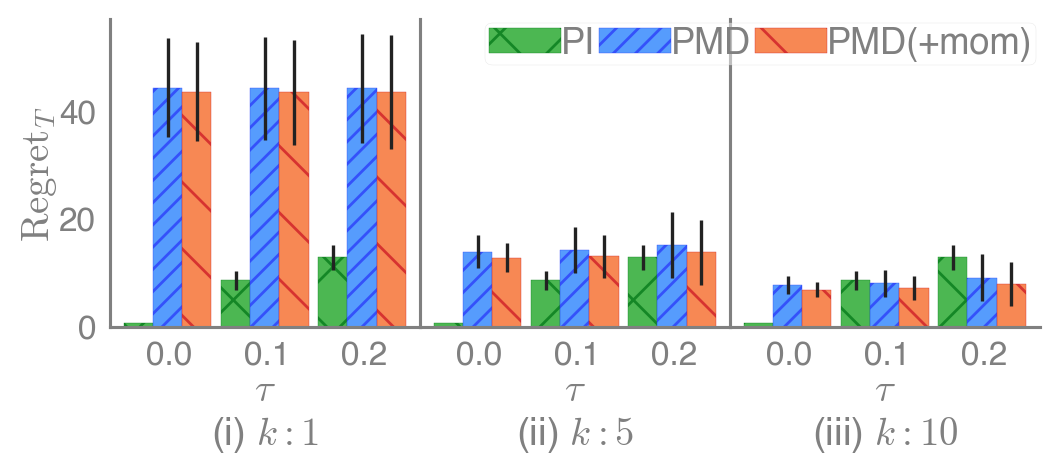

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import colormaps as cmaps
import src.plot_tiny_mdps
src.plot_tiny_mdps = importlib.reload(src.plot_tiny_mdps)
import src.plot_tiny_mdps
from src.plot_tiny_mdps import plot_multiple_bars
initial_policy = 0
Ts = [20, 20, 40]
newcmap3 = cmaps.WhiteGreen.shift(0.25).cut(0.25, "right").cut(0.25, "left")
newcmap2 = cmaps.cet_l_kbc_r.shift(0.25).cut(0.5, "right")
newcmap1 = cmaps.WhiteYellowOrangeRed.shift(0.25).cut(0.25, "right").cut(0.25, "left")
from collections import defaultdict
mdp_no = 0
mdp = mdps[mdp_no]
kk = 0
k = 1
data_list = []
subset_k_list = [1, 5, 10]
for kk, k in enumerate(k_list):
    if k in subset_k_list:
        data = defaultdict(list)
        for tau_ind, tau in enumerate(tau1_list):
            vals_pi = []
            for i in range(n_seeds):
                vals_pi.append(np.cumsum(pi[tau_ind][2][mdp_no][initial_policy][i]["suboptimality_tp1__rho"][:T])[-1])
            v_rho_pi_std = np.std(vals_pi, axis=0)
            v_rho_pi_mean = np.mean(vals_pi, axis=0)
    
            vals_pmd = []
            for i in range(n_seeds):
                vals_pmd.append(np.cumsum(pmd[tau_ind][kk][2][mdp_no][initial_policy][i]["suboptimality_tp1__rho"][:T])[-1])
            v_rho_pmd_std = np.std(vals_pmd, axis=0)
            v_rho_pmd_mean = np.mean(vals_pmd, axis=0)
    
            vals_mom = []
            for i in range(n_seeds):
                vals_mom.append(np.cumsum(lazy_momentum[tau_ind][kk][2][mdp_no][initial_policy][i]["suboptimality_tp1__rho"][:T])[-1])
            v_rho_mom_std = np.std(vals_mom, axis=0)
            v_rho_mom_mean = np.mean(vals_mom, axis=0)
    
            data[f"PI"].append((v_rho_pi_mean, v_rho_pi_std))
            data[f"PMD"].append((v_rho_pmd_mean, v_rho_pmd_std))
            data[f"PMD(+mom)"].append((v_rho_mom_mean, v_rho_mom_std))
        data_list.append(data)

hatches = {f"PI": 'x',
           f"PMD": "///",
           f"PMD(+mom)": '\\'
           }
colors = {f"PI": newcmap3, f"PMD": newcmap2,
          f"PMD(+mom)": newcmap1}
y_label = r'$\operatorname{Regret}_T$'
tau_label = r'\tau'
x_label_list=[f"${tau_label}$\n{['(i)','(ii)','(iii)'][kk]} $k:{k}$" for kk,k in enumerate(subset_k_list)]
plot_multiple_bars(data_list, tau1_list, colors, hatches,
                   labelsize=14, textsize=13,
                   legendsize=13,
                   ticklabelsize=12, y_label=y_label, x_label_list=x_label_list,figname=f"inexact__controlled", savefig=True)